# Using TensorFlow FedAvg on Colorectal Histology dataset

In [1]:
%matplotlib inline

In [2]:
import codecs
import os
import sys
import zipfile
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds


# Setup
*****

This examples runs with three organizations. Two organizations provide datasets, while a third
one provides the algorithm.

In the activation following code cell, we define the different organizations needed for our FL experiment.



In [3]:
from substra import Client

N_CLIENTS = 3

# Every computation will run in `subprocess` mode, where everything runs locally in Python
# subprocesses.
# Ohers backend_types are:
# "docker" mode where computations run locally in docker containers
# "remote" mode where computations run remotely (you need to have a deployed platform for that)
client_0 = Client(backend_type="subprocess")
client_1 = Client(backend_type="subprocess")
client_2 = Client(backend_type="subprocess")
# To run in remote mode you have to also use the function `Client.login(username, password)`

clients = {
    client_0.organization_info().organization_id: client_0,
    client_1.organization_info().organization_id: client_1,
    client_2.organization_info().organization_id: client_2,
}


# Store organization IDs
ORGS_ID = list(clients.keys())
ALGO_ORG_ID = ORGS_ID[0]  # Algo provider is defined as the first organization.
DATA_PROVIDER_ORGS_ID = ORGS_ID[1:]  # Data providers orgs are the two last organizations.

# Data Preparation

In [4]:
from tf_fedavg_assets.dataset.histo_dataset import setup_histo

# Create the temporary directory for generated data
(pathlib.Path.cwd() / "tmp").mkdir(exist_ok=True)
data_path = pathlib.Path.cwd() / "tmp" / "data_histo"

setup_histo(data_path, len(DATA_PROVIDER_ORGS_ID))

# Visualizing the Dataset

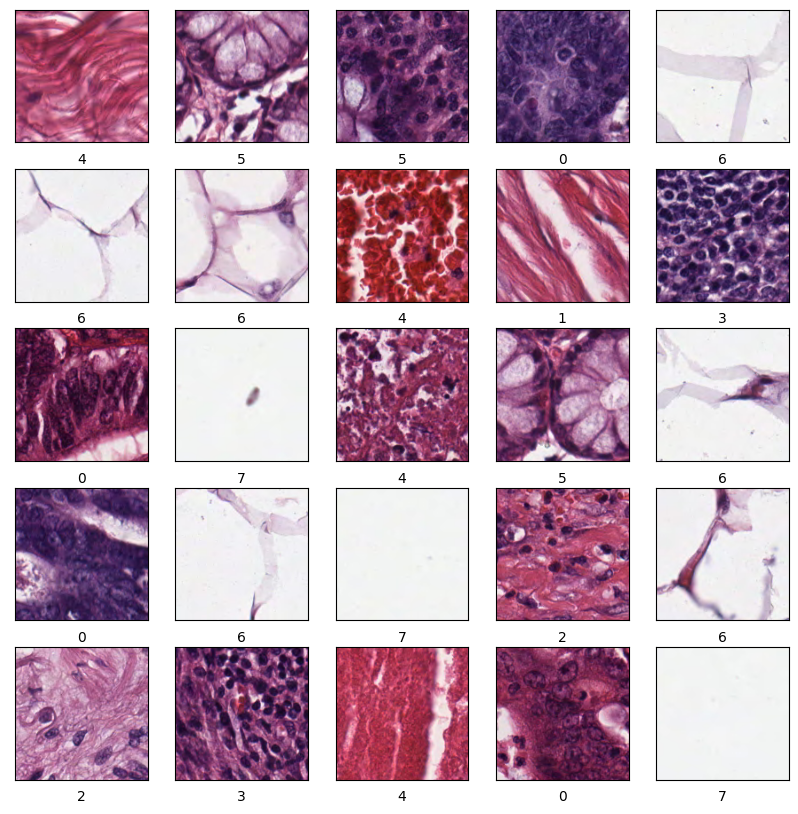

In [5]:
# visualize dataset
images = np.load('tmp/data_histo/org_1/train/train_images.npy')
labels = np.load('tmp/data_histo/org_1/train/train_labels.npy')

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(labels[i])
plt.show()
    

In [ ]:
min(labels), max(labels) # labels go from 0 to 7

(0, 7)

# Dataset registration

In [ ]:
from substra.sdk.schemas import DatasetSpec
from substra.sdk.schemas import Permissions
from substra.sdk.schemas import DataSampleSpec

assets_directory = pathlib.Path.cwd() / "tf_fedavg_assets"
dataset_keys = {}
train_datasample_keys = {}
test_datasample_keys = {}

for i, org_id in enumerate(DATA_PROVIDER_ORGS_ID):

    client = clients[org_id]

    permissions_dataset = Permissions(public=False, authorized_ids=[ALGO_ORG_ID])

    # DatasetSpec is the specification of a dataset. It makes sure every field
    # is well defined, and that our dataset is ready to be registered.
    # The real dataset object is created in the add_dataset method.

    dataset = DatasetSpec(
        name="histo",
        type="npy",
        data_opener=assets_directory / "dataset" / "histo_opener.py",
        description=assets_directory / "dataset" / "description.md",
        permissions=permissions_dataset,
        logs_permission=permissions_dataset,
    )
    dataset_keys[org_id] = client.add_dataset(dataset)
    assert dataset_keys[org_id], "Missing dataset key"

    # Add the training data on each organization.
    # now data_sample will have keys like "images" and "labels"
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "train",
    )
    train_datasample_keys[org_id] = client.add_data_sample(data_sample)

    # Add the testing data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "test",
    )
    test_datasample_keys[org_id] = client.add_data_sample(data_sample)

# Metric registration

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

from substrafl.dependency import Dependency
from substrafl.remote.register import add_metric

permissions_metric = Permissions(public=False, authorized_ids=[ALGO_ORG_ID] + DATA_PROVIDER_ORGS_ID)

# The Dependency object is instantiated in order to install the right libraries in
# the Python environment of each organization.
metric_deps = Dependency(pypi_dependencies=["numpy==1.23.1", "scikit-learn==1.1.1"])


def accuracy(datasamples, predictions_path):
    y_true = datasamples["labels"]
    y_pred = np.load(predictions_path)

    return accuracy_score(y_true, np.argmax(y_pred, axis=1))


metric_key = add_metric(
    client=clients[ALGO_ORG_ID],
    metric_function=accuracy,
    permissions=permissions_metric,
    dependencies=metric_deps,
)

# Model definition

In [ ]:
seed = 42
tf.random.set_seed(seed)

In [ ]:
class CNN(tf.keras.Sequential):
    def __init__(self):
        super(CNN, self).__init__(layers=[
            tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)),
            tf.keras.layers.Conv2D(32, 5, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 5, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(128, 5, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(8, activation= 'softmax')
        ])

In [ ]:
model = CNN()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Specifying on how much data to train

In [ ]:
from substrafl.index_generator import NpIndexGenerator

# Number of model updates between each FL strategy aggregation.
NUM_UPDATES = 100

# Number of samples per update.
BATCH_SIZE = 32

index_generator = NpIndexGenerator(
    batch_size=BATCH_SIZE,
    num_updates=NUM_UPDATES,
)

# TensorFlow Dataset definition

In [ ]:
img = images[0][None,...]

In [ ]:
img2 = img / 255

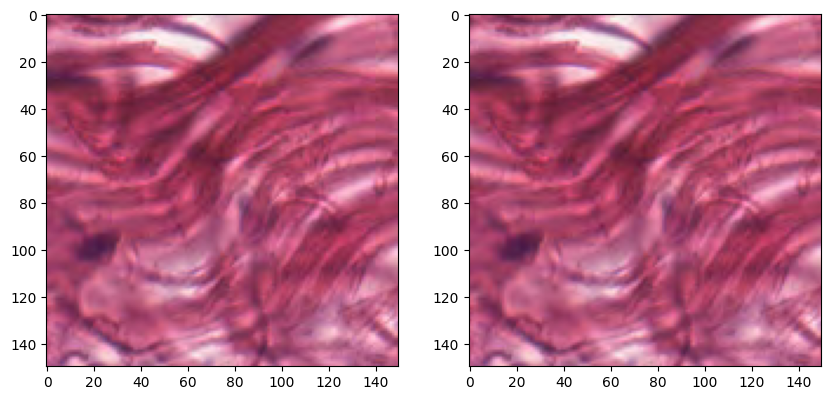

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(img2[0])
plt.show()


In [ ]:
images[0][None,...].shape

(1, 150, 150, 3)

In [ ]:
images[0][...].shape

(150, 150, 3)

In [ ]:
images[0].shape

(150, 150, 3)

In [ ]:
images2 = np.copy(images)

In [ ]:
images2 = images2 / 255.

In [ ]:
images

array([[[[173,  82, 113],
         [186,  95, 126],
         [213,  98, 139],
         ...,
         [213, 106, 148],
         [214, 100, 143],
         [221, 107, 150]],

        [[153,  63,  96],
         [170,  80, 113],
         [196,  90, 128],
         ...,
         [215, 109, 147],
         [224, 114, 151],
         [225, 115, 152]],

        [[134,  46,  78],
         [153,  65,  97],
         [175,  81, 115],
         ...,
         [204, 100, 133],
         [209, 106, 135],
         [200,  97, 126]],

        ...,

        [[189,  93, 141],
         [203, 107, 155],
         [192, 100, 149],
         ...,
         [195, 100, 138],
         [197,  97, 135],
         [198,  98, 136]],

        [[181,  89, 136],
         [184,  92, 139],
         [184,  98, 145],
         ...,
         [188,  98, 134],
         [184,  92, 131],
         [186,  94, 133]],

        [[184,  94, 140],
         [178,  88, 134],
         [169,  85, 134],
         ...,
         [183,  91, 128],
        

In [ ]:
images2

array([[[[0.67843137, 0.32156863, 0.44313725],
         [0.72941176, 0.37254902, 0.49411765],
         [0.83529412, 0.38431373, 0.54509804],
         ...,
         [0.83529412, 0.41568627, 0.58039216],
         [0.83921569, 0.39215686, 0.56078431],
         [0.86666667, 0.41960784, 0.58823529]],

        [[0.6       , 0.24705882, 0.37647059],
         [0.66666667, 0.31372549, 0.44313725],
         [0.76862745, 0.35294118, 0.50196078],
         ...,
         [0.84313725, 0.42745098, 0.57647059],
         [0.87843137, 0.44705882, 0.59215686],
         [0.88235294, 0.45098039, 0.59607843]],

        [[0.5254902 , 0.18039216, 0.30588235],
         [0.6       , 0.25490196, 0.38039216],
         [0.68627451, 0.31764706, 0.45098039],
         ...,
         [0.8       , 0.39215686, 0.52156863],
         [0.81960784, 0.41568627, 0.52941176],
         [0.78431373, 0.38039216, 0.49411765]],

        ...,

        [[0.74117647, 0.36470588, 0.55294118],
         [0.79607843, 0.41960784, 0.60784314]

In [ ]:
images[0].dtype, images2[0].dtype

(dtype('uint8'), dtype('float64'))

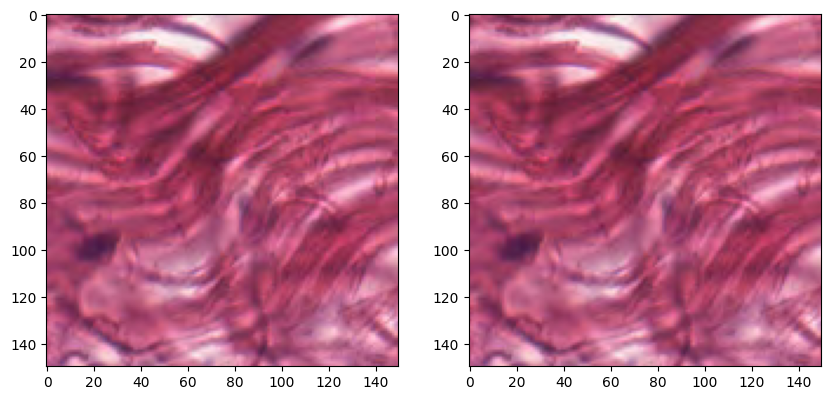

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(images2[0])
plt.show()


Normalization worked but is not visible on images, maybe a problem of cmap ?

In [7]:
# to test the previous class, we recreate a data_sample
# we assume a datasample is like
# dict('images': np.array,
#      'labels': np.array)
data_sample1 = dict(
    {
    'images': images[:10],
    'labels': labels[:10]
    }
)

# SubstraFL algo definition

In [ ]:
from tensorflow_algorithms.tf_fed_avg_algo import TFFedAvgAlgo
from tensorflow_algorithms import my_classes
TFDataset = my_classes.TFDataset

class MyAlgo(TFFedAvgAlgo):
    def __init__(self):
        super().__init__(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            index_generator=index_generator,
            dataset=TFDataset,
            seed=seed,
        )

ModuleNotFoundError: No module named 'weight_manager'

Federated Learning strategies
=============================

A FL strategy specifies how to train a model on distributed data.
The most well known strategy is the Federated Averaging strategy: train locally a model on every organization,
then aggregate the weight updates from every organization, and then apply locally at each organization the averaged
updates.



In [ ]:
from substrafl.strategies import FedAvg

strategy = FedAvg()

Where to train where to aggregate
=================================

We specify on which data we want to train our model, using the `substrafl_doc/api/nodes:TrainDataNode` object.
Here we train on the two datasets that we have registered earlier.

The `substrafl_doc/api/nodes:AggregationNode` specifies the organization on which the aggregation operation
will be computed.



In [ ]:
from substrafl.nodes import TrainDataNode
from substrafl.nodes import AggregationNode


aggregation_node = AggregationNode(ALGO_ORG_ID)

train_data_nodes = list()

for org_id in DATA_PROVIDER_ORGS_ID:

    # Create the Train Data Node (or training task) and save it in a list
    train_data_node = TrainDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[train_datasample_keys[org_id]],
    )
    train_data_nodes.append(train_data_node)

Where and when to test
======================

With the same logic as the train nodes, we create `substrafl_doc/api/nodes:TestDataNode` to specify on which
data we want to test our model.

The `substrafl_doc/api/evaluation_strategy:Evaluation Strategy` defines where and at which frequency we
evaluate the model, using the given metric(s) that you registered in a previous section.



In [ ]:
from substrafl.nodes import TestDataNode
from substrafl.evaluation_strategy import EvaluationStrategy


test_data_nodes = list()

for org_id in DATA_PROVIDER_ORGS_ID:

    # Create the Test Data Node (or testing task) and save it in a list
    test_data_node = TestDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        test_data_sample_keys=[test_datasample_keys[org_id]],
        metric_keys=[metric_key],
    )
    test_data_nodes.append(test_data_node)

# Test at the end of every round
my_eval_strategy = EvaluationStrategy(test_data_nodes=test_data_nodes, rounds=1)

Running the experiment
**********************

We now have all the necessary objects to launch our experiment. Please see a summary below of all the objects we created so far:

- A `documentation/references/sdk:Client` to add or retrieve the assets of our experiment, using their keys to
  identify them.
- An `Torch algorithm <substrafl_doc/api/algorithms:Torch Algorithms>`_ to define the training parameters *(optimizer, train
  function, predict function, etc...)*.
- A `Federated Strategy <substrafl_doc/api/strategies:Strategies>`_, to specify how to train the model on
  distributed data.
- `Train data nodes <substrafl_doc/api/nodes:TrainDataNode>`_ to indicate on which data to train.
- An `substrafl_doc/api/evaluation_strategy:Evaluation Strategy`, to define where and at which frequency we
  evaluate the model.
- An `substrafl_doc/api/nodes:AggregationNode`, to specify the organization on which the aggregation operation
  will be computed.
- The **number of rounds**, a round being defined by a local training step followed by an aggregation operation.
- An **experiment folder** to save a summary of the operation made.
- The `substrafl_doc/api/dependency:Dependency` to define the libraries on which the experiment needs to run.



In [ ]:
from substrafl.experiment import execute_experiment

# A round is defined by a local training step followed by an aggregation operation
NUM_ROUNDS = 3

# The Dependency object is instantiated in order to install the right libraries in
# the Python environment of each organization.
algo_deps = Dependency(pypi_dependencies=["numpy==1.23.1", "torch==1.11.0"])

compute_plan = execute_experiment(
    client=clients[ALGO_ORG_ID],
    algo=MyAlgo(),
    strategy=strategy,
    train_data_nodes=train_data_nodes,
    evaluation_strategy=my_eval_strategy,
    aggregation_node=aggregation_node,
    num_rounds=NUM_ROUNDS,
    experiment_folder=str(pathlib.Path.cwd() / "tmp" / "experiment_summaries"),
    dependencies=algo_deps,
)

NameError: name 'MyAlgo' is not defined